In [1]:
# importing required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

In [2]:
def exponential_variogram_model(d, range_, sill, nugget):
    '''
    Exponential variogram function.
    
    Parameters:
        d (numpy.array): lag distances
        range_ (float): range parameter of model
        sill (float): sill parameter of model
        nugget (float): nugget parameter of model
        
    Return:
        gamma (numpy.array): calculated semivariances
    '''
    # calculate partial sill
    psill = sill - nugget 
    
    # semivariance for exponential model
    gamma = psill * (1. - np.exp(-d / (range_))) + nugget
    
    return gamma

def exponential_covariance_model(d, range_, sill, nugget):
    '''
    Exponential variogram function.
    
    Parameters:
        d (numpy.array): lag distances
        range_ (float): range parameter of model
        sill (float): sill parameter of model
        nugget (float): nugget parameter of model
        
    Return:
        cov (numpy.array): calculated covariances
    '''
    # calculate partial sill
    psill = sill - nugget
    
    # covariance for exponential model
    cov = psill * (np.exp(-(np.absolute(d) / (range_))))
    
    return cov

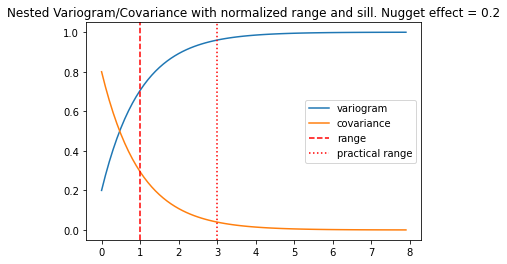

In [3]:
# Plot models of spatial correlation
d = np.arange(0,8,0.1)
vario_plot = exponential_variogram_model(d, range_=1, sill=1, nugget=0.2)
cov_plot = exponential_covariance_model(d, range_=1, sill=1,nugget=0.2)

plt.plot(d, vario_plot, label='variogram')
plt.plot(d, cov_plot, label='covariance')
plt.axvline(x=1,color='red', linestyle='--', label='range')
plt.axvline(x=3,color='red', linestyle=':', label='practical range' )
plt.title('Nested Variogram/Covariance with normalized range and sill. Nugget effect = 0.2')
plt.legend()

In [4]:
def kriging_1D(krig_locs, data, range_, sill, nugget, nugget_type='pure'): 
    '''
    Function to perform kriging over 1D discretized domain.

    Parameters:
        krig_locs (numpy.array): discretized set of 1D loactions to interpolate.
        data (numpy.array): input data locations and values.
        range_ (float): range parameter of model
        sill (float): sill parameter of model
        nugget (float): nugget parameter of model
        nugget_type (str): either "pure", "exact" or "filtered".

    Return:
        results_df (pandas.DataFrame): results of kriging interpolation.
    '''
    
    # empty arrays for results (estimated values and variances)
    kriging_result_vals = np.zeros(len(krig_locs))
    kriging_result_vars = np.zeros(len(krig_locs))
    
    # calculate distances between all input data points
    dist_all_to_all = np.zeros((len(data), len(data)))
    for i in range(len(data)):
        dist_all_to_all[:,i] = np.absolute(data[:, 0]-data[i, 0])
    
    dist_grid_to_all = np.zeros((len(krig_locs), len(data)))
    for i in range(len(krig_locs)):
        dist_grid_to_all[i,:] = np.absolute(data[:, 0]-krig_locs[i])
    # calculate distances between all grid points and all input data point)
                                            
    # Main loop that goes through whole domain (grid)
    for i in range(len(krig_locs)):

        # STEP 1: Multiple if elif conditions to define moving neighbourhood:
        a = dist_grid_to_all[i]
        b = dist_all_to_all
        prop = data[:, 1]
        # STEP 2: Multiple if elif conditions to calculate kriging at point
        val, var = ordinary_kriging(a, b, prop,range_, sill,nugget, nugget_effect=nugget_type)
        # STEP 3: Save results
        kriging_result_vals[i] = val
        kriging_result_vars[i] = var
        # create dataframe of results data for calling
        d = {'X_loc': krig_locs, 'est_value': kriging_result_vals, 'est_variance': kriging_result_vars}
        results_df = pd.DataFrame(data=d)
        
    return results_df
    
def ordinary_kriging(b, a, prop, range_, sill, nugget, nugget_effect):
        '''
        Ordinary kriging interpolation for single point.

        Parameters:
            a (numpy.array): distance vector between target point and input data locations
            b (numpy.array): distance matrix between input data locations
            prop (numpy.array): property values at input data locations
            range_ (float): range parameter of model
            sill (float): sill parameter of model
            nugget (float): nugget parameter of model
            nugget_effect (str): either "pure", "exact" or "filtered".

        Return:
            result (float): calculated semivariances
            pred_var (float):
            w (numpy.array): set of calculated kriging weights
        '''
        # empty matrix building for OK
        shape = len(a)
        C = np.zeros((shape + 1, shape + 1))
        c = np.zeros((shape + 1))
        w = np.zeros((shape + 1))

        # filling matirces based on model for spatial correlation
        C[:shape, :shape] = exponential_variogram_model(a,range_,sill,nugget)
        c[:shape] = exponential_variogram_model(b,range_,sill,nugget)

        np.fill_diagonal(C, 0)

        # for exact kriging
        if nugget_effect == 'exact':
            c[c==nugget]=0

        # matrix setup for OK
        C[shape, :] = 1.0
        C[:, shape] = 1.0
        C[shape, shape] = 0.0
        c[shape] = 1.0

        # Solve Kriging equations
        w = np.linalg.solve(C, c)

        # calculating estimate and variance for kriging
        pred_var = w[shape] + np.sum(w[:shape] * c[:shape])

        # for filtered kriging
        if nugget_effect == 'filtered':
            pred_var = pred_var-nugget

        result = np.dot(prop, w[:shape])

        return result, pred_var

In [5]:
# Simple 1D example with two locations and data values at these locations
locs = np.arange(0,3,0.1)
inp = np.array([[1,-1],[2,1]])

In [6]:
def compare(range_, sill, nugget):
    '''
    Function for interactive plot of comparison between nugget effect types.

    Parameters:
        range_ (float): range parameter of model
        sill (float): sill parameter of model
        nugget (float): nugget parameter of model
    '''
    
    results_df1 = kriging_1D(locs, inp, range_=range_, sill=sill, nugget=nugget, nugget_type='exact')
    loc1 = results_df1['X_loc'].values
    val1 = results_df1['est_value'].values
    var1 = results_df1['est_variance']
    
    results_df2 = kriging_1D(locs, inp, range_=range_, sill=sill, nugget=nugget, nugget_type='new_value')
    loc2 = results_df2['X_loc'].values
    val2 = results_df2['est_value'].values
    var2 = results_df2['est_variance']
    
    results_df3 = kriging_1D(locs, inp, range_=range_, sill=sill, nugget=nugget, nugget_type='filtered')
    loc3 = results_df3['X_loc'].values
    val3 = results_df3['est_value'].values
    var3 = results_df3['est_variance']

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    
    axes[0].plot(inp[:,0], inp[:,1], 's', markersize=10, fillstyle='none', color='black', label='data value')
    axes[0].plot(loc1, val1, '-o', label='exact')
    axes[0].plot(loc2, val2, '-o', markersize=3, label='new value/filtered')
    axes[0].set_ylim(-1.5,1.5)
    axes[0].legend()
    
    axes[1].set_ylim(0,1.5)
    axes[1].plot(loc1, np.sqrt(np.round(var1,2)))
    axes[1].plot(loc2, np.sqrt(var2))
    axes[1].plot(loc3, np.sqrt(var3))

In [7]:
interact(compare, range_=(1,11,1), sill=(0.5,1.5,0.1), nugget=(0,1,0.1));

interactive(children=(IntSlider(value=6, description='range_', max=11, min=1), FloatSlider(value=1.0, descript…

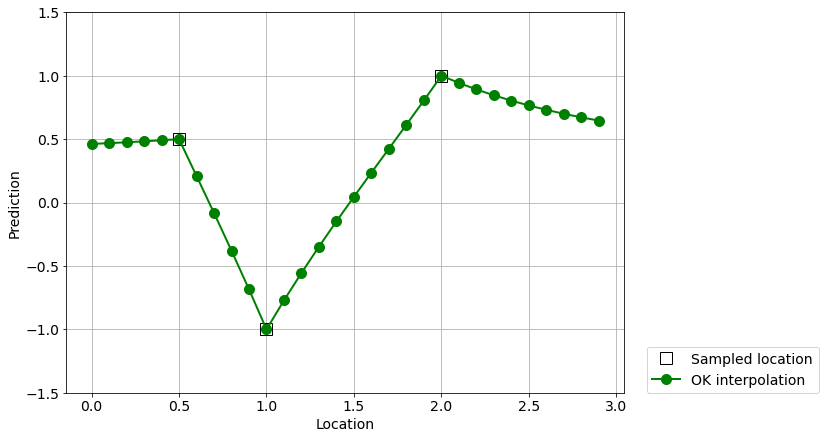

In [8]:
# Create figure 3 (a)
locs = np.arange(0,3,0.1)
inp = np.array([[0.5,0.5],[1,-1],[2,1]])

range_=1
nugget=0.0
sill=1
    
results_df1 = kriging_1D(locs, inp, range_=range_, sill=sill, nugget=nugget, nugget_type='exact')
loc1 = results_df1['X_loc'].values
val1 = results_df1['est_value'].values
var1 = results_df1['est_variance']
    
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
    
axes.plot(inp[:,0], inp[:,1], 's', markersize=12, fillstyle='none', color='black', label='Sampled location')
axes.plot(loc1, val1, '-o', label='OK interpolation', markersize=10, linewidth=2, color="green")

axes.set_ylim(-1.5,1.5)
#axes.set_ylim(-1.5,5)
axes.set_ylabel("Prediction", fontsize=14)
axes.set_xlabel("Location",fontsize=14)

axes.legend(loc=(1.04,0), fontsize=14)
axes.grid()
axes.tick_params(axis='x', labelsize=14)
axes.tick_params(axis='y', labelsize=14)

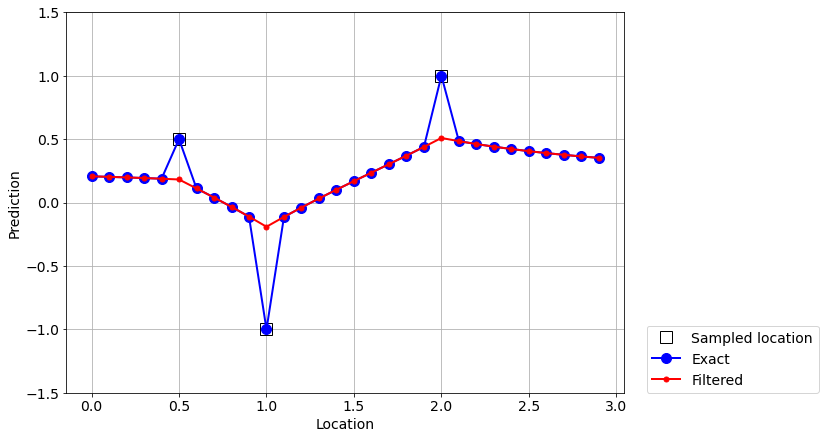

In [9]:
# Create figure 3 (b)
locs = np.arange(0,3,0.1)
inp = np.array([[0.5,0.5],[1,-1],[2,1]])

range_=1
nugget=0.5
sill=1
    
results_df1 = kriging_1D(locs, inp, range_=range_, sill=sill, nugget=nugget, nugget_type='exact')
loc1 = results_df1['X_loc'].values
val1 = results_df1['est_value'].values
var1 = results_df1['est_variance']
    
results_df2 = kriging_1D(locs, inp, range_=range_, sill=sill, nugget=nugget, nugget_type='new_value')
loc2 = results_df2['X_loc'].values
val2 = results_df2['est_value'].values
var2 = results_df2['est_variance']


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
    
axes.plot(inp[:,0], inp[:,1], 's', markersize=12, fillstyle='none', color='black', label='Sampled location')
axes.plot(loc1, val1, '-o', label='Exact', markersize=10, linewidth=2, color="blue")
axes.plot(loc2, val2, '-o', markersize=5, label='Filtered', color='red', linewidth=2)
axes.set_ylim(-1.5,1.5)
#axes.set_ylim(-1.5,5)
axes.set_ylabel("Prediction", fontsize=14)
axes.set_xlabel("Location",fontsize=14)

axes.legend(loc=(1.04,0), fontsize=14)
axes.grid()
axes.tick_params(axis='x', labelsize=14)
axes.tick_params(axis='y', labelsize=14)
